In [1]:
import pandas as pd
import numpy as np

H3_FEATURES = "h3_features.csv"
df = pd.read_csv(H3_FEATURES)

# Same preprocessing as your script
for c in ["rmsd_fv_all_ctx", "rmsd_h3_ctx", "rmsd_h3_local", "rmsd_fv_seqmap", "h3_rmsd"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

df["error_cat"] = df["error"].fillna("").astype(str).str.strip().map(lambda x: "ok" if x == "" else "err")
df["n_chains_used"] = pd.to_numeric(df.get("n_chains_used", np.nan), errors="coerce")

ok_global = (df["error_cat"] == "ok") & (df["n_chains_used"] == 2) & np.isfinite(df.get("rmsd_fv_seqmap", np.nan))
ok_h3 = (df.get("h3_error", "").fillna("").astype(str).str.strip() == "") & np.isfinite(df.get("h3_rmsd", np.nan))

# Mimic your pooling
df_ok_unique = df.loc[ok_h3].drop_duplicates(subset=["id"], keep="first").copy()
df_ok_unique["method"] = "Pooled"

print("Rows ok_h3 (all methods):", int(ok_h3.sum()))
print("Rows after drop_duplicates(id):", len(df_ok_unique))

# Show n used per feature (this is what appears in legend)
features = [
    "h3_len","h3_entropy","h3_num_unique","h3_kd_mean","h3_frac_hydrophobic",
    "h3_net_charge_pH7","h3_kmer3_rarity_dataset","h3_frac_gly_pro","h3_frac_aromatic",
    "pred_conf_fv_bfac_mean"
]
features = [f for f in features if f in df_ok_unique.columns]

n_used = []
for f in features:
    vals = pd.to_numeric(df_ok_unique[f], errors="coerce").to_numpy()
    n_used.append({"feature": f, "n_finite_used_in_ecdf": int(np.isfinite(vals).sum())})

display(pd.DataFrame(n_used).sort_values("n_finite_used_in_ecdf", ascending=False))

Rows ok_h3 (all methods): 1136
Rows after drop_duplicates(id): 571


,feature,n_finite_used_in_ecdf
0,h3_len,571
1,h3_entropy,571
2,h3_num_unique,571
3,h3_kd_mean,571
4,h3_frac_hydrophobic,571
5,h3_net_charge_pH7,571
6,h3_kmer3_rarity_dataset,571
7,h3_frac_gly_pro,571
8,h3_frac_aromatic,571
9,pred_conf_fv_bfac_mean,571


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

H3_FEATURES = "h3_features.csv"
df = pd.read_csv(H3_FEATURES)

# Normalize IDs
df["id_norm"] = df["id"].astype(str).str.strip().str.upper()
df["base_pdb_id"] = df["id_norm"].str.split("_").str[0]

# Numeric columns
for c in ["rmsd_h3_ctx", "rmsd_h3_local", "rmsd_fv_noh3_ctx", "rmsd_fv_all_ctx"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Keep OK rows only
df_ok = df[df["error"].fillna("").astype(str).str.strip() == ""].copy()

# Pivot to get both methods on same target
pv = df_ok.pivot_table(index="base_pdb_id", columns="method", values="rmsd_h3_ctx", aggfunc="first")
need = ["IGFold", "ABodyBuilder2"]
pv = pv.dropna(subset=need, how="any").copy()

# Your "remove method-specific effects" agreement filter
pv["delta_abs"] = (pv["ABodyBuilder2"] - pv["IGFold"]).abs()
agree = pv[pv["delta_abs"] <= 1.5].copy()
agree["h3_rmsd_median_agree"] = agree[need].median(axis=1)

print("Targets with both methods + agree within 1.5Å:", len(agree))
agree.head()

Targets with both methods + agree within 1.5Å: 473


method,ABodyBuilder2,IGFold,delta_abs,h3_rmsd_median_agree
base_pdb_id,,,,
7DF1,4.522705,4.521500,0.001205,4.522102
7FGJ,0.861542,1.107569,0.246027,0.984556
7FJC,3.112673,3.255914,0.143241,3.184293
7OX1,4.634580,4.196747,0.437833,4.415663
7OX4,3.326842,3.336438,0.009596,3.331640


In [8]:
# Cell X — Correlations for the specific feature panel you care about (target-level, agree-set)
from scipy import stats
import pandas as pd
import numpy as np

FEATURE_PANEL = [
    "h3_len", "h3_entropy", "h3_num_unique",
    "h3_net_charge_pH7", "h3_kd_mean", "h3_frac_hydrophobic",
    "h3_frac_gly_pro", "h3_frac_aromatic",
    "h3_has_cys", "h3_has_cys_pair", "h3_has_glyco_motif",
    "h3_p_count", "h3_p_max_run",
    "h3_kmer3_rarity_dataset",
]

# y = median H3 RMSD across AB2/IgFold for targets where they agree within 1.5Å
y = pd.to_numeric(target["h3_rmsd_median_agree"], errors="coerce").to_numpy(dtype=float)

rows = []
for feat in FEATURE_PANEL:
    if feat not in target.columns:
        rows.append({"feature": feat, "status": "MISSING_COLUMN"})
        continue

    x = pd.to_numeric(target[feat], errors="coerce").to_numpy(dtype=float)
    mask = np.isfinite(x) & np.isfinite(y)
    n = int(mask.sum())

    if n < 30:
        rows.append({"feature": feat, "n": n, "status": "TOO_FEW_POINTS"})
        continue

    # If the feature is constant after filtering, correlation is undefined
    if np.nanstd(x[mask]) < 1e-12:
        rows.append({"feature": feat, "n": n, "status": "CONSTANT_FEATURE"})
        continue

    rho, p = stats.spearmanr(x[mask], y[mask])
    rows.append({
        "feature": feat,
        "n": n,
        "spearman_rho": float(rho),
        "p_value": float(p),
        "status": "OK",
    })

corr_panel = pd.DataFrame(rows)

# Nice ordering: strongest |rho| first among OK rows, then the rest
ok = corr_panel["status"] == "OK"
corr_panel.loc[ok, "abs_rho"] = corr_panel.loc[ok, "spearman_rho"].abs()
corr_panel = pd.concat([
    corr_panel[ok].sort_values(["abs_rho", "p_value"], ascending=[False, True]),
    corr_panel[~ok]
], ignore_index=True).drop(columns=["abs_rho"], errors="ignore")

display(corr_panel)

,feature,n,spearman_rho,p_value,status
0,h3_len,473,0.599009,2.143824e-47,OK
1,h3_num_unique,473,0.439621,8.980520e-24,OK
2,h3_entropy,473,0.356369,1.306707e-15,OK
3,h3_kmer3_rarity_dataset,473,0.259266,1.053562e-08,OK
4,h3_p_count,473,0.254026,2.116079e-08,OK
5,h3_p_max_run,473,0.245874,6.073165e-08,OK
6,h3_frac_hydrophobic,473,-0.082046,7.463911e-02,OK
7,h3_has_cys_pair,473,0.080027,8.209517e-02,OK
8,h3_frac_gly_pro,473,0.066919,1.461757e-01,OK
9,h3_has_cys,473,0.065307,1.561624e-01,OK


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def ecdf(a: np.ndarray):
    a = np.asarray(a, dtype=float)
    a = a[np.isfinite(a)]
    if len(a) == 0:
        return np.array([]), np.array([])
    x = np.sort(a)
    y = np.arange(1, len(x) + 1) / len(x)
    return x, y

FEATURE_PANEL = [
    "h3_len", "h3_entropy", "h3_num_unique",
    "h3_net_charge_pH7", "h3_kd_mean", "h3_frac_hydrophobic",
    "h3_frac_gly_pro", "h3_frac_aromatic",
    "h3_has_cys", "h3_has_cys_pair", "h3_has_glyco_motif",
    "h3_p_count", "h3_p_max_run",
    "h3_kmer3_rarity_dataset",
]

In [3]:
# Prefer rows with a non-empty H3 sequence
rep = df.copy()
rep["h3_seq"] = rep["h3_seq"].fillna("").astype(str)
rep["_h3_len_tmp"] = rep["h3_seq"].str.len()

rep = (
    rep.sort_values("_h3_len_tmp", ascending=False)
       .drop_duplicates("base_pdb_id", keep="first")
       .set_index("base_pdb_id")
       .drop(columns=["_h3_len_tmp"])
)

target = agree.join(rep, how="left")
print("Joined target-level table shape:", target.shape)

target[["h3_rmsd_median_agree", "delta_abs", "h3_seq", "h3_len"]].head()

Joined target-level table shape: (473, 63)


,h3_rmsd_median_agree,delta_abs,h3_seq,h3_len
base_pdb_id,,,,
7DF1,4.522102,0.001205,GYYDILTGSRPIFFDI,16
7FGJ,0.984556,0.246027,STYYSGALDY,10
7FJC,3.184293,0.143241,GGGRRLQFDYFDY,13
7OX1,4.415663,0.437833,AGEGRSWYPGYYYGMDY,17
7OX4,3.331640,0.009596,EDHYSDTHGWNDY,13


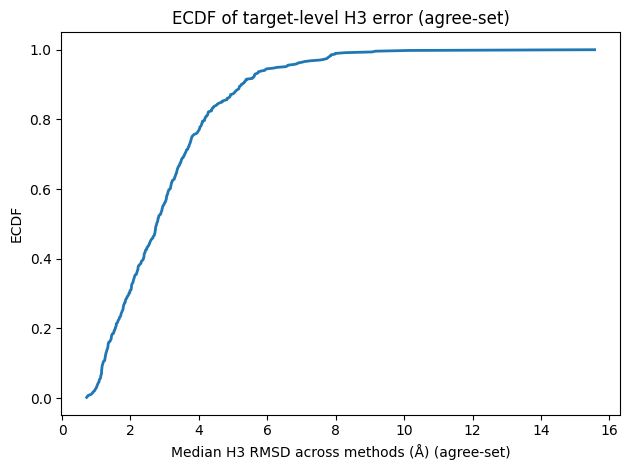

n targets: 473
median: 2.7644925000000002
p90: 5.241827


In [10]:
y = pd.to_numeric(target["h3_rmsd_median_agree"], errors="coerce").to_numpy(dtype=float)
x, yy = ecdf(y)

plt.figure()
plt.plot(x, yy, linewidth=2.0)
plt.xlabel("Median H3 RMSD across methods (Å) (agree-set)")
plt.ylabel("ECDF")
plt.title("ECDF of target-level H3 error (agree-set)")
plt.tight_layout()
plt.show()

print("n targets:", np.isfinite(y).sum())
print("median:", float(np.nanmedian(y)))
print("p90:", float(np.nanquantile(y, 0.90)))

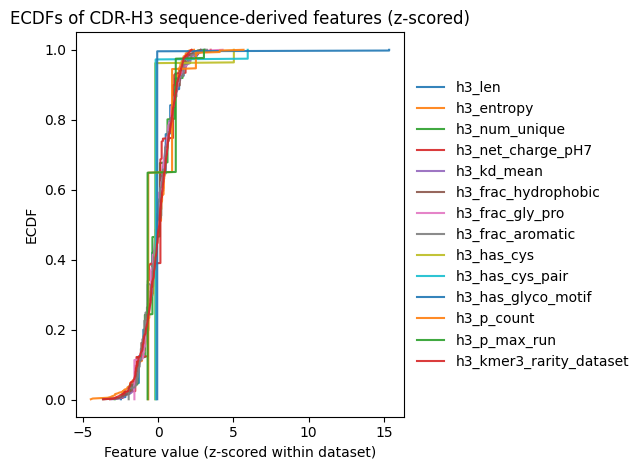

Features plotted: 14 / 14


In [12]:
# Build a numeric matrix for your features
feat_df = target.copy()

# Coerce to numeric; binaries (0/1) are fine too
for f in FEATURE_PANEL:
    if f in feat_df.columns:
        feat_df[f] = pd.to_numeric(feat_df[f], errors="coerce")

# Z-score each feature so all ECDFs are comparable on one axis
# (skip columns that are missing or constant)
z_data = {}
for f in FEATURE_PANEL:
    if f not in feat_df.columns:
        continue
    v = feat_df[f].to_numpy(dtype=float)
    v = v[np.isfinite(v)]
    if len(v) < 30:
        continue
    mu = float(np.mean(v))
    sd = float(np.std(v, ddof=0))
    if sd < 1e-12:
        continue
    z = (feat_df[f].to_numpy(dtype=float) - mu) / sd
    z_data[f] = z

plt.figure()
for f, z in z_data.items():
    x, y = ecdf(z)
    if len(x) == 0:
        continue
    plt.plot(x, y, linewidth=1.5, alpha=0.9, label=f)

plt.xlabel("Feature value (z-scored within dataset)")
plt.ylabel("ECDF")
plt.title("ECDFs of CDR-H3 sequence-derived features (z-scored)")
plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5), frameon=False)
plt.tight_layout()
plt.show()

print("Features plotted:", len(z_data), "/", sum(f in feat_df.columns for f in FEATURE_PANEL))
missing = [f for f in FEATURE_PANEL if f not in feat_df.columns]
if missing:
    print("Missing columns:", missing)

/var/folders/j0/vl76fnl96tq_cn2kx7l63r0w0000gn/T/ipykernel_4437/3927157838.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for qname, g in d.groupby("q", sort=True):


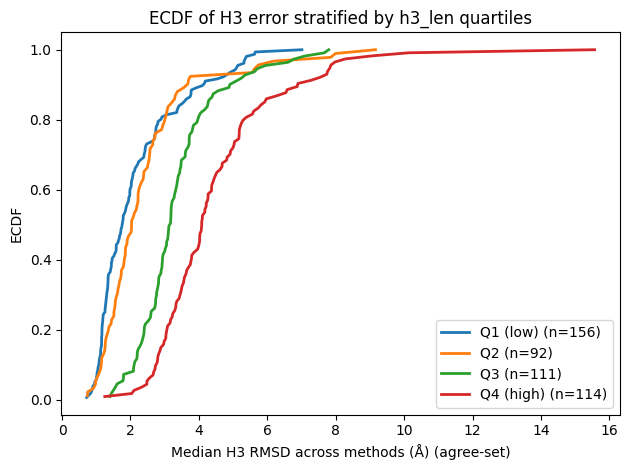

In [13]:
FEATURE_TO_STRATIFY = "h3_len"  # try: h3_len, h3_entropy, h3_kmer3_rarity_dataset

d = target.copy()
d["y"] = pd.to_numeric(d["h3_rmsd_median_agree"], errors="coerce")
d["x"] = pd.to_numeric(d[FEATURE_TO_STRATIFY], errors="coerce")
d = d[np.isfinite(d["x"]) & np.isfinite(d["y"])].copy()

# quartiles
d["q"] = pd.qcut(d["x"], 4, labels=["Q1 (low)", "Q2", "Q3", "Q4 (high)"])

plt.figure()
for qname, g in d.groupby("q", sort=True):
    x, y = ecdf(g["y"].to_numpy(dtype=float))
    plt.plot(x, y, linewidth=2.0, label=f"{qname} (n={len(g)})")

plt.xlabel("Median H3 RMSD across methods (Å) (agree-set)")
plt.ylabel("ECDF")
plt.title(f"ECDF of H3 error stratified by {FEATURE_TO_STRATIFY} quartiles")
plt.legend()
plt.tight_layout()
plt.show()

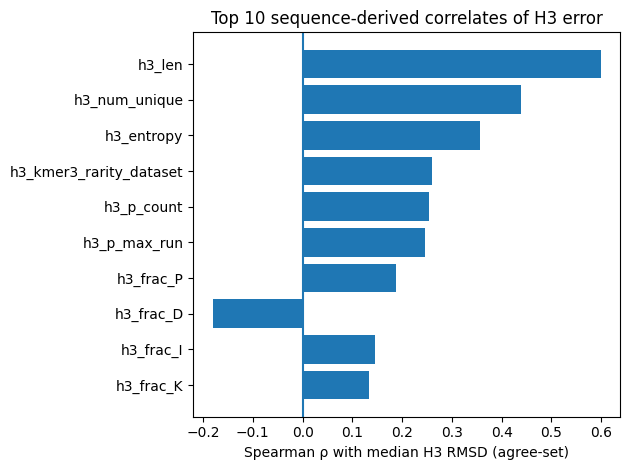

,feature,n,spearman_rho,p_value,abs_rho
0,h3_len,473,0.599009,2.143824e-47,0.599009
1,h3_num_unique,473,0.439621,8.980520e-24,0.439621
2,h3_entropy,473,0.356369,1.306707e-15,0.356369
3,h3_kmer3_rarity_dataset,473,0.259266,1.053562e-08,0.259266
4,h3_p_count,473,0.254026,2.116079e-08,0.254026
5,h3_p_max_run,473,0.245874,6.073165e-08,0.245874
6,h3_frac_P,473,0.187932,3.903067e-05,0.187932
7,h3_frac_D,473,-0.180551,7.853166e-05,0.180551
8,h3_frac_I,473,0.145872,1.466992e-03,0.145872
9,h3_frac_K,473,0.133463,3.637777e-03,0.133463


In [4]:
drop_cols = {
    "IGFold", "ABodyBuilder2", "delta_abs",
    "h3_rmsd_median_agree", "h3_rmsd", "h3_rmsd_ctx", "h3_rmsd_local",
    "rmsd_fv_noh3_ctx", "rmsd_fv_all_ctx", "rmsd_h3_ctx", "rmsd_h3_local",
    "pred_conf_h3_bfac_mean", "pred_conf_fv_bfac_mean",
}

y = pd.to_numeric(target["h3_rmsd_median_agree"], errors="coerce").to_numpy(dtype=float)

seq_features = [c for c in target.columns if c.startswith("h3_") and c not in drop_cols and c != "h3_seq"]

rows = []
for c in seq_features:
    x = pd.to_numeric(target[c], errors="coerce").to_numpy(dtype=float)
    m = np.isfinite(x) & np.isfinite(y)
    if m.sum() < 60:
        continue
    rho, p = stats.spearmanr(x[m], y[m])
    rows.append((c, int(m.sum()), float(rho), float(p)))

seq_corr = pd.DataFrame(rows, columns=["feature", "n", "spearman_rho", "p_value"])
seq_corr["abs_rho"] = seq_corr["spearman_rho"].abs()
seq_corr = seq_corr.sort_values(["abs_rho", "p_value"], ascending=[False, True]).reset_index(drop=True)

top_k = 10
top = seq_corr.head(top_k).copy()

plt.figure()
plt.barh(top["feature"][::-1], top["spearman_rho"][::-1])
plt.axvline(0.0)
plt.xlabel("Spearman ρ with median H3 RMSD (agree-set)")
plt.title(f"Top {top_k} sequence-derived correlates of H3 error")
plt.tight_layout()
plt.show()

seq_corr.head(15)

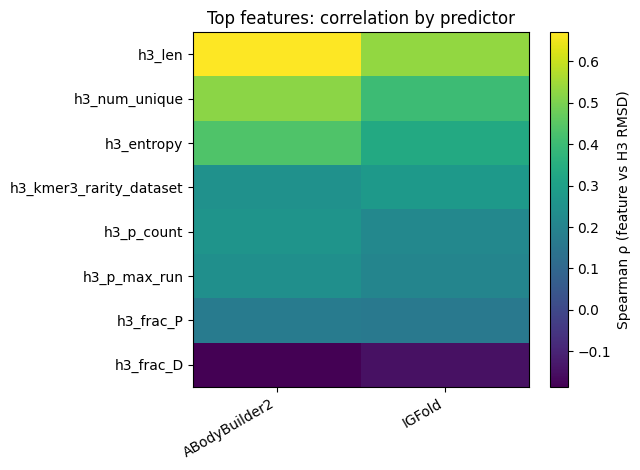

In [5]:
top_feats = seq_corr.head(8)["feature"].tolist()
methods = sorted(df_ok["method"].astype(str).unique().tolist())

mat = np.full((len(top_feats), len(methods)), np.nan, dtype=float)

for i, f in enumerate(top_feats):
    for j, mname in enumerate(methods):
        g = df_ok[df_ok["method"].astype(str) == mname]
        x = pd.to_numeric(g[f], errors="coerce").to_numpy(dtype=float)
        yy = pd.to_numeric(g["rmsd_h3_ctx"], errors="coerce").to_numpy(dtype=float)
        mask = np.isfinite(x) & np.isfinite(yy)
        if mask.sum() >= 60:
            mat[i, j] = stats.spearmanr(x[mask], yy[mask]).statistic

plt.figure()
im = plt.imshow(mat, aspect="auto", interpolation="nearest")
plt.colorbar(im, label="Spearman ρ (feature vs H3 RMSD)")
plt.yticks(np.arange(len(top_feats)), top_feats)
plt.xticks(np.arange(len(methods)), methods, rotation=30, ha="right")
plt.title("Top features: correlation by predictor")
plt.tight_layout()
plt.show()

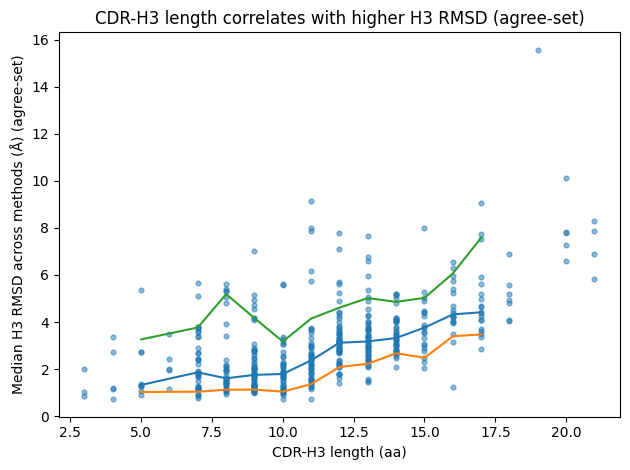

,h3_len,q10,q50,q90,n
0,5,1.028776,1.327681,3.262228,9
1,7,1.038905,1.863117,3.768057,37
2,8,1.125291,1.609078,5.186711,36
3,9,1.129293,1.755903,4.164375,61
4,10,1.043917,1.794198,3.171616,43
5,11,1.362029,2.370939,4.147782,49
6,12,2.088440,3.120525,4.612517,57
7,13,2.227015,3.177082,5.018128,54
8,14,2.673446,3.321658,4.855355,39
9,15,2.479544,3.763622,5.025925,21


In [6]:
x = pd.to_numeric(target["h3_len"], errors="coerce").to_numpy(dtype=float)
y = pd.to_numeric(target["h3_rmsd_median_agree"], errors="coerce").to_numpy(dtype=float)
mask = np.isfinite(x) & np.isfinite(y)
x = x[mask].astype(int)
y = y[mask]

plt.figure()
plt.scatter(x, y, s=12, alpha=0.5)

xs = np.unique(x)
rows = []
for xv in xs:
    yy = y[x == xv]
    if len(yy) < 8:
        continue
    rows.append((xv, float(np.quantile(yy, 0.10)), float(np.median(yy)), float(np.quantile(yy, 0.90)), len(yy)))

q = pd.DataFrame(rows, columns=["h3_len", "q10", "q50", "q90", "n"])
plt.plot(q["h3_len"], q["q50"])
plt.plot(q["h3_len"], q["q10"])
plt.plot(q["h3_len"], q["q90"])

plt.xlabel("CDR-H3 length (aa)")
plt.ylabel("Median H3 RMSD across methods (Å) (agree-set)")
plt.title("CDR-H3 length correlates with higher H3 RMSD (agree-set)")
plt.tight_layout()
plt.show()

q.head(12)

In [7]:
rng = np.random.default_rng(0)

def boot_spearman(feature: str, n_boot: int = 1000):
    xx = pd.to_numeric(target[feature], errors="coerce").to_numpy(dtype=float)
    yy = pd.to_numeric(target["h3_rmsd_median_agree"], errors="coerce").to_numpy(dtype=float)
    m = np.isfinite(xx) & np.isfinite(yy)
    xx, yy = xx[m], yy[m]
    n = len(xx)
    if n < 80:
        return np.array([])
    out = np.empty(n_boot, dtype=float)
    for b in range(n_boot):
        idx = rng.integers(0, n, size=n)
        out[b] = stats.spearmanr(xx[idx], yy[idx]).statistic
    return out

top_feats = seq_corr.head(6)["feature"].tolist()
boot_rows = []
for f in top_feats:
    rhos = boot_spearman(f, n_boot=500)
    boot_rows.append({
        "feature": f,
        "rho_point": float(seq_corr[seq_corr["feature"] == f]["spearman_rho"].iloc[0]),
        "rho_boot_med": float(np.median(rhos)) if len(rhos) else np.nan,
        "rho_boot_ci95_lo": float(np.quantile(rhos, 0.025)) if len(rhos) else np.nan,
        "rho_boot_ci95_hi": float(np.quantile(rhos, 0.975)) if len(rhos) else np.nan,
    })

pd.DataFrame(boot_rows)

,feature,rho_point,rho_boot_med,rho_boot_ci95_lo,rho_boot_ci95_hi
0,h3_len,0.599009,0.599760,0.531366,0.670177
1,h3_num_unique,0.439621,0.439122,0.357877,0.509762
2,h3_entropy,0.356369,0.355374,0.274481,0.424221
3,h3_kmer3_rarity_dataset,0.259266,0.260861,0.169272,0.339363
4,h3_p_count,0.254026,0.254229,0.171604,0.335301
5,h3_p_max_run,0.245874,0.241014,0.164487,0.330354
